### Funções

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Dec 15 11:26:44 2019

Visualização dos patches ruidosos a partir do grafo k-NN

"""
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.io import imread
import random
import sys
import warnings
import time
import skimage
import statistics
import networkx as nx
import matplotlib.pyplot as plt
import skimage.io
import skimage.measure
import numpy as np
from cuml.manifold import UMAP
from numpy import eye
import sklearn.neighbors as sknn
from numba import njit   # just in time compiler (acelera loops)
import os
import numpy as np



def read_directories(directory, img=None, exclude_json=None):
    # Get a list of filenames in the specified directory
    filenames = []
    for filename in os.listdir(directory):
        if img is not None:
            # If 'img' is provided, filter filenames containing it
            if img in filename:   
                filenames.append(filename)
        elif exclude_json is not None:
            filenames.append(filename.replace('.json',''))     
        else:
            filenames.append(filename)    
    return filenames

# Para evitar warning de divisão por zero
warnings.simplefilter(action='ignore')

'''
Espelhamento das bordas da imagem A de maneira simétrica
A função pad do numpy não é supertada pelo numba! (para acelerar com jit)
Substitui a função: img_n = np.pad(ruidosa, ((f, f), (f, f)), 'symmetric')
f é o parâmetro (largura das bordas)
'''
@njit
def mirror(A, f):
    n = A.shape[0]
    m = A.shape[1]

    nlin = A.shape[0] + 2*f          # Altura da nova imagem com borda
    ncol = A.shape[1] + 2*f          # Largura da nova imagem com borda
    B = np.zeros((nlin, ncol))      # Inicializa matriz de saída com zeros

    B[f:nlin-f, f:ncol-f] = A       # Copia imagem original no centro

    # Preenche os quatro cantos com reflexão (espelhamento)
    B[0:f, 0:f] = np.flip(A[0:f, 0:f])                          # 1o quadrante
    B[0:f, ncol-f:ncol] = np.flip(A[0:f, m-f:m])                # 2o quadrante
    B[nlin-f:nlin, 0:f] = np.flip(A[n-f:n, 0:f])                # 3o quadrante
    B[nlin-f:nlin, ncol-f:ncol] = np.flip(A[n-f:n, m-f:m])      # 4o quadrante

     # Preenche as bordas (superior, inferior, esquerda, direita)
    B[0:f, f:ncol-f] = np.flipud(A[0:f, :])             # cima
    B[nlin-f:nlin, f:ncol-f] = np.flipud(A[n-f:n, :])   # baixo
    B[f:nlin-f, 0:f] = np.fliplr(A[:, 0:f])             # esquerda
    B[f:nlin-f, ncol-f:ncol] = np.fliplr(A[:, m-f:m])   # direita
    return B

'''
Extrai todos os patches em uma janela local centrada em (i, j)
f: metade do tamanho do patch
t: raio da janela de busca
'''
@njit
def Extract_patches_local(img, i, j, f, t):
    m, n = img.shape                             # Dimensões da imagem
    tamanho_patch = (2*f + 1)*(2*f + 1)          # Tamanho do vetor de um patch

    img_n = mirror(img, f)                       # Adiciona borda espelhada

    im = i + f;                                  # Compensação por causa do padding
    jn = j + f;

    patch_central = img_n[im-f:(im+f)+1, jn-f:(jn+f)+1].copy()      # Patch central
    central = patch_central.reshape((1, patch_central.shape[0]*patch_central.shape[1]))[-1]

    # Limites da janela de busca
    rmin = max(im-t, f)
    rmax = min(im+t, m+f)
    smin = max(jn-t, f)
    smax = min(jn+t, n+f)

    num_elem = (rmax - rmin + 1)*(smax - smin + 1)  # Total de patches na janela

    dataset = np.zeros((num_elem, tamanho_patch))  # Inicializa matriz de patches
    k = 0                                           # Índice do patch atual no dataset

    for r in range(rmin, rmax+1):
        for s in range(smin, smax+1):
            W = img_n[r-f:(r+f)+1, s-f:(s+f)+1].copy()  # Extrai patch da posição atual
            neighbor = W.reshape((1, W.shape[0]*W.shape[1]))[-1]  # Transforma em vetor
            dataset[k, :] = neighbor.copy()              # Adiciona ao dataset

            if (central == neighbor).all():              # Salva índice do patch central
                source = k

            k = k + 1

    return dataset, source   # Retorna todos os patches da janela e o índice do patch central

'''
Constrói o grafo k-NN a partir de uma matriz de dados (n amostras x m features)
'''
def build_KNN_Graph(dados, k):
    KNNG = sknn.kneighbors_graph(dados, n_neighbors=k, mode='distance')  # Grafo de k-vizinhos com pesos = distâncias
    G = nx.from_scipy_sparse_array(KNNG)  # Converte o grafo para formato NetworkX
    return G

def get_umap_embedding(data, n_components=3, random_state=42):
    reducer = UMAP(n_components=n_components, random_state=random_state)
    embedding = reducer.fit_transform(data)
    return embedding

'''
Plota um grafo NetworkX com destaque para um nó central
layout: 'kamada' ou outro (default = spring)
'''
def plota_grafo(G, centro, dimensions=2, layout='spring'):
    n = len(G.nodes)  # Número de nós no grafo

    if dimensions == 3:
        # Para 3D, o layout deve gerar coordenadas 3D
        if layout == 'umap': # UMAP embeddings already provide 3D positions
            pos = nx.get_node_attributes(G, 'pos_3d')
        else:
            # Fallback for other 3D layouts, though UMAP is preferred for this task
            pos = nx.spring_layout(G, dim=3)
            
        fig = plt.figure(figsize=(12, 10))
        ax = fig.add_subplot(111, projection='3d')

        # Desenha arestas
        for edge in G.edges():
            x = np.array([pos[edge[0]][0], pos[edge[1]][0]])
            y = np.array([pos[edge[0]][1], pos[edge[1]][1]])
            z = np.array([pos[edge[0]][2], pos[edge[1]][2]])
            ax.plot(x, y, z, c='gray', alpha=0.7, linewidth=0.1)

        # Desenha nós
        node_xyz = np.array([pos[v] for v in G.nodes()])
        ax.scatter(node_xyz[:, 0], node_xyz[:, 1], node_xyz[:, 2], s=35, c='black', alpha=0.7)

        # Destaque no centro
        if centro is not None and centro in G.nodes:
            ax.scatter(pos[centro][0], pos[centro][1], pos[centro][2], s=35, c='red', alpha=0.7)

    else:  # 2D plotting
        if layout == 'kamada':
            pos = nx.kamada_kawai_layout(G)  # Layout de Kamada-Kawai
        else:
            pos = nx.spring_layout(G)  # Layout de mola (spring)

        plt.figure(figsize=(12, 8))
        nx.draw_networkx(G, pos, node_size=10, with_labels=False, width=0.1, alpha=0.7)  # Desenha grafo
        if centro is not None and centro in G.nodes:
            nx.draw_networkx_nodes(G, pos, node_size=10, nodelist=[centro], node_color='red', alpha=0.7)  # Destaque no centro

    plt.show()  # Exibe o gráfico
"""
Espelhamento das bordas da imagem A de maneira simétrica
A função pad do numpy não é supertada pelo numba! (para acelerar com jit)
Substitui a função: img_n = np.pad(ruidosa, ((f, f), (f, f)), 'symmetric')
f é o parâmetro (largura das bordas)
"""
@njit
def mirror(A, f):
    n = A.shape[0]
    m = A.shape[1]

    nlin = A.shape[0] + 2*f          # Altura da nova imagem com borda
    ncol = A.shape[1] + 2*f          # Largura da nova imagem com borda
    B = np.zeros((nlin, ncol))      # Inicializa matriz de saída com zeros

    B[f:nlin-f, f:ncol-f] = A       # Copia imagem original no centro

    # Preenche os quatro cantos com reflexão (espelhamento)
    B[0:f, 0:f] = np.flip(A[0:f, 0:f])                          # 1o quadrante
    B[0:f, ncol-f:ncol] = np.flip(A[0:f, m-f:m])                # 2o quadrante
    B[nlin-f:nlin, 0:f] = np.flip(A[n-f:n, 0:f])                # 3o quadrante
    B[nlin-f:nlin, ncol-f:ncol] = np.flip(A[n-f:n, m-f:m])      # 4o quadrante

     # Preenche as bordas (superior, inferior, esquerda, direita)
    B[0:f, f:ncol-f] = np.flipud(A[0:f, :])             # cima
    B[nlin-f:nlin, f:ncol-f] = np.flipud(A[n-f:n, :])   # baixo
    B[f:nlin-f, 0:f] = np.fliplr(A[:, 0:f])             # esquerda
    B[f:nlin-f, ncol-f:ncol] = np.fliplr(A[:, m-f:m])   # direita
    return B

"""
Extrai todos os patches em uma janela local centrada em (i, j)
f: metade do tamanho do patch
t: raio da janela de busca
"""
@njit
def Extract_patches_local(img, i, j, f, t):
    m, n = img.shape                             # Dimensões da imagem
    tamanho_patch = (2*f + 1)*(2*f + 1)          # Tamanho do vetor de um patch

    img_n = mirror(img, f)                       # Adiciona borda espelhada

    im = i + f;                                  # Compensação por causa do padding
    jn = j + f;

    patch_central = img_n[im-f:(im+f)+1, jn-f:(jn+f)+1].copy()      # Patch central
    central = patch_central.reshape((1, patch_central.shape[0]*patch_central.shape[1]))[-1]

    # Limites da janela de busca
    rmin = max(im-t, f)
    rmax = min(im+t, m+f)
    smin = max(jn-t, f)
    smax = min(jn+t, n+f)

    num_elem = (rmax - rmin + 1)*(smax - smin + 1)  # Total de patches na janela

    dataset = np.zeros((num_elem, tamanho_patch))  # Inicializa matriz de patches
    k = 0                                           # Índice do patch atual no dataset

    for r in range(rmin, rmax+1):
        for s in range(smin, smax+1):
            W = img_n[r-f:(r+f)+1, s-f:(s+f)+1].copy()  # Extrai patch da posição atual
            neighbor = W.reshape((1, W.shape[0]*W.shape[1]))[-1]  # Transforma em vetor
            dataset[k, :] = neighbor.copy()              # Adiciona ao dataset

            if (central == neighbor).all():              # Salva índice do patch central
                source = k

            k = k + 1

    return dataset, source   # Retorna todos os patches da janela e o índice do patch central

"""
Constrói o grafo k-NN a partir de uma matriz de dados (n amostras x m features)
"""
def build_KNN_Graph(dados, k):
    KNNG = sknn.kneighbors_graph(dados, n_neighbors=k, mode='distance')  # Grafo de k-vizinhos com pesos = distâncias
    G = nx.from_scipy_sparse_array(KNNG)  # Converte o grafo para formato NetworkX
    return G

def get_umap_embedding(data, n_components=3, random_state=42):
    reducer = UMAP(n_components=n_components, random_state=random_state)
    embedding = reducer.fit_transform(data)
    return embedding

"""
Plota um grafo NetworkX com destaque para um nó central
layout: 'kamada' ou outro (default = spring)
"""
def plota_grafo(G, centro, dimensions=2, layout='spring'):
    n = len(G.nodes)  # Número de nós no grafo

    if dimensions == 3:
        # Para 3D, o layout deve gerar coordenadas 3D
        if layout == 'umap': # UMAP embeddings already provide 3D positions
            pos = nx.get_node_attributes(G, 'pos_3d')
        else:
            # Fallback for other 3D layouts, though UMAP is preferred for this task
            pos = nx.spring_layout(G, dim=3)
            
        fig = plt.figure(figsize=(12, 10))
        ax = fig.add_subplot(111, projection='3d')

        # Desenha arestas
        for edge in G.edges():
            x = np.array([pos[edge[0]][0], pos[edge[1]][0]])
            y = np.array([pos[edge[0]][1], pos[edge[1]][1]])
            z = np.array([pos[edge[0]][2], pos[edge[1]][2]])
            ax.plot(x, y, z, c='gray', alpha=0.7, linewidth=0.1)

        # Desenha nós
        node_xyz = np.array([pos[v] for v in G.nodes()])
        ax.scatter(node_xyz[:, 0], node_xyz[:, 1], node_xyz[:, 2], s=35, c='black', alpha=0.7)

        # Destaque no centro
        if centro is not None and centro in G.nodes:
            ax.scatter(pos[centro][0], pos[centro][1], pos[centro][2], s=35, c='red', alpha=0.7)

    else:  # 2D plotting
        if layout == 'kamada':
            pos = nx.kamada_kawai_layout(G)  # Layout de Kamada-Kawai
        else:
            pos = nx.spring_layout(G)  # Layout de mola (spring)

        plt.figure(figsize=(12, 8))
        nx.draw_networkx(G, pos, node_size=10, with_labels=False, width=0.1, alpha=0.7)  # Desenha grafo
        if centro is not None and centro in G.nodes:
            nx.draw_networkx_nodes(G, pos, node_size=10, nodelist=[centro], node_color='red', alpha=0.7)  # Destaque no centro

    plt.show()  # Exibe o gráfico



def pad_imagem_espelhada(imagem, pad=50):
    return np.pad(imagem, ((pad, pad), (pad, pad)), mode='symmetric')


def detectar_n_regioes_sem_sobreposicao(imagem_gray, f=25, limiar_var=20.0, max_regioes=20):
    altura, largura = imagem_gray.shape[0], imagem_gray.shape[1]
    array_centros = []
    usados = np.zeros_like(imagem_gray, dtype=bool)

    candidatos = []

    for i in range(f, altura - f):
        for j in range(f, largura - f):
            patch = imagem_gray[i-f:i+f+1, j-f:j+f+1]
            var = np.var(patch)
            if var >= limiar_var:
                candidatos.append((var, (j, i)))  # (x, y)

    candidatos.sort(reverse=True)  # ordena por variância decrescente

    for _, (x, y) in candidatos:
        if not usados[y-f:y+f+1, x-f:x+f+1].any():
            array_centros.append((x, y))
            usados[y-f:y+f+1, x-f:x+f+1] = True
        if len(array_centros) == max_regioes:
            break

    return array_centros

def exibir_imagem_com_retangulos(img, centers, window_size=(50, 50), raio_circulo=2):
    img_copy = img.copy()
    half_w = window_size[0] // 2
    half_h = window_size[1] // 2

    for (cx, cy) in centers:
        top_left = (cx - half_w, cy - half_h)
        bottom_right = (cx + half_w, cy + half_h)

        # Desenha retângulo verde
        cv2.rectangle(img_copy, top_left, bottom_right, (0, 255, 0), 2)

        # Desenha círculo vermelho no centro
        if 0 <= cy < img_copy.shape[0] and 0 <= cx < img_copy.shape[1]:
            cv2.circle(img_copy, (cx, cy), raio_circulo, (0, 0, 255), -1)  # vermelho preenchido

    # Exibe com matplotlib
    img_rgb = cv2.cvtColor(img_copy.astype(np.uint8), cv2.COLOR_BGR2RGB)

    return img_rgb

In [7]:
import pickle
def compute_patchspace_metrics(patches):

    # diversidade (linhas únicas)
    unique_rows = np.unique(patches, axis=0).shape[0]

    # energia média (variância média dos patches)
    energy = np.mean(np.var(patches, axis=1))

    # SVD rápido
    # usamos full_matrices=False para eficiência
    U, S, Vt = np.linalg.svd(patches, full_matrices=False)

    # rank efetivo (singular values acima de threshold)
    tol = 1e-6
    rank = np.sum(S > tol)

    # razão de energia espectral
    spectral_ratio = S[0] / (np.sum(S) + 1e-12)

    return {
        "unique_rows": unique_rows,
        "rank": rank,
        "energy": energy,
        "spectral_ratio": spectral_ratio
    }


def compute_graph_metrics(G, embedding, patch_center):

    degrees = np.array([d for _, d in G.degree()])
    avg_degree = np.mean(degrees)
    degree_var = np.var(degrees)

    density = nx.density(G)
    clustering = nx.average_clustering(G)

    # distância média ao centro no embedding
    center_coords = embedding[patch_center]
    dists = np.linalg.norm(embedding - center_coords, axis=1)
    avg_dist_center = np.mean(dists)

    return {
        "avg_degree": avg_degree,
        "degree_var": degree_var,
        "density": density,
        "clustering": clustering,
        "avg_dist_center": avg_dist_center
    }

def detectar_regioes_por_tipo(
    imagem_gray,
    f=25,
    max_regioes=10,
    tipo="nao_uniforme"
):

    altura, largura = imagem_gray.shape
    usados = np.zeros_like(imagem_gray, dtype=bool)
    candidatos = []
    variancias = []

    # ===============================
    # 1️⃣ CALCULAR TODAS VARIÂNCIAS
    # ===============================
    for i in range(f, altura - f):
        for j in range(f, largura - f):
            patch = imagem_gray[i-f:i+f+1, j-f:j+f+1]
            var = np.var(patch)
            variancias.append(var)

    variancias = np.array(variancias)

    # Percentis adaptativos
    limiar_uniforme = np.percentile(variancias, 10)
    limiar_nao_uniforme = np.percentile(variancias, 90)

    # ===============================
    # 2️⃣ SELEÇÃO POR TIPO
    # ===============================
    for i in range(f, altura - f):
        for j in range(f, largura - f):

            patch = imagem_gray[i-f:i+f+1, j-f:j+f+1]
            var = np.var(patch)

            if tipo == "uniforme" and var <= limiar_uniforme:
                candidatos.append((var, (j, i)))

            elif tipo == "nao_uniforme" and var >= limiar_nao_uniforme:
                candidatos.append((var, (j, i)))

            elif tipo == "mesclada":
                if limiar_uniforme < var < limiar_nao_uniforme:
                    candidatos.append((var, (j, i)))

    # Ordenação adequada
    if tipo == "uniforme":
        candidatos.sort()  # menor variância primeiro
    else:
        candidatos.sort(reverse=True)

    array_centros = []

    for _, (x, y) in candidatos:
        if not usados[y-f:y+f+1, x-f:x+f+1].any():
            array_centros.append((x, y))
            usados[y-f:y+f+1, x-f:x+f+1] = True
        if len(array_centros) == max_regioes:
            break

    return array_centros



Processando tipo: uniforme


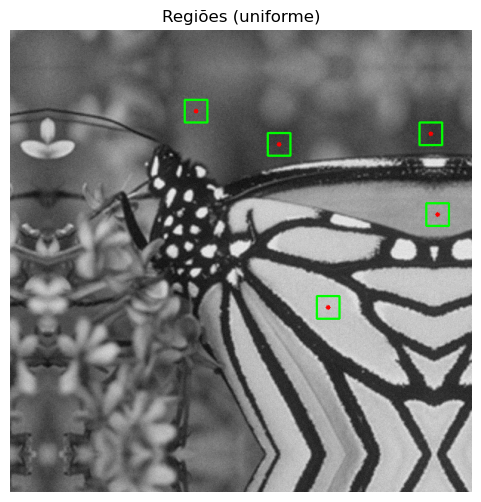


--- σ = 5 ---

--- σ = 50 ---


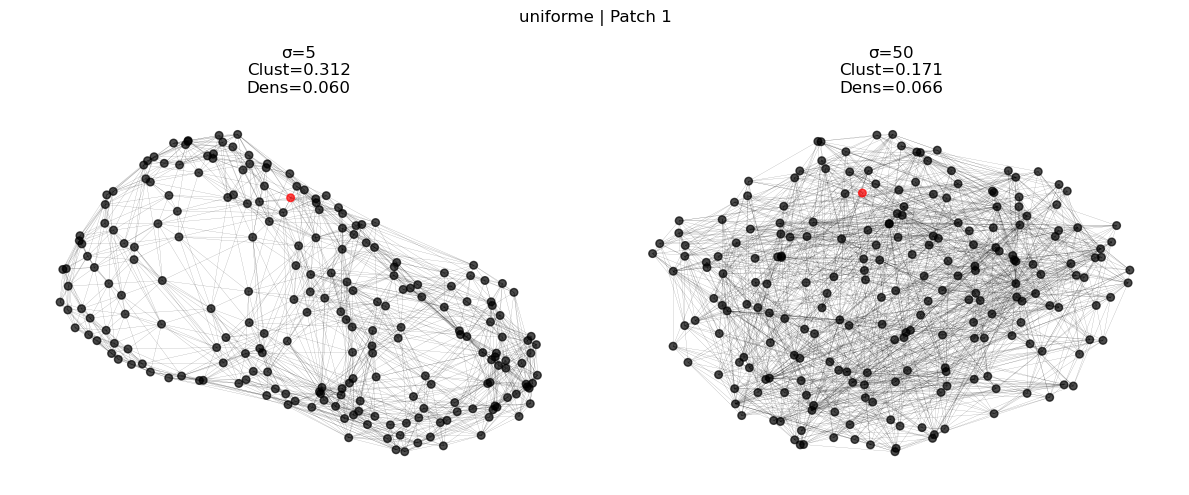

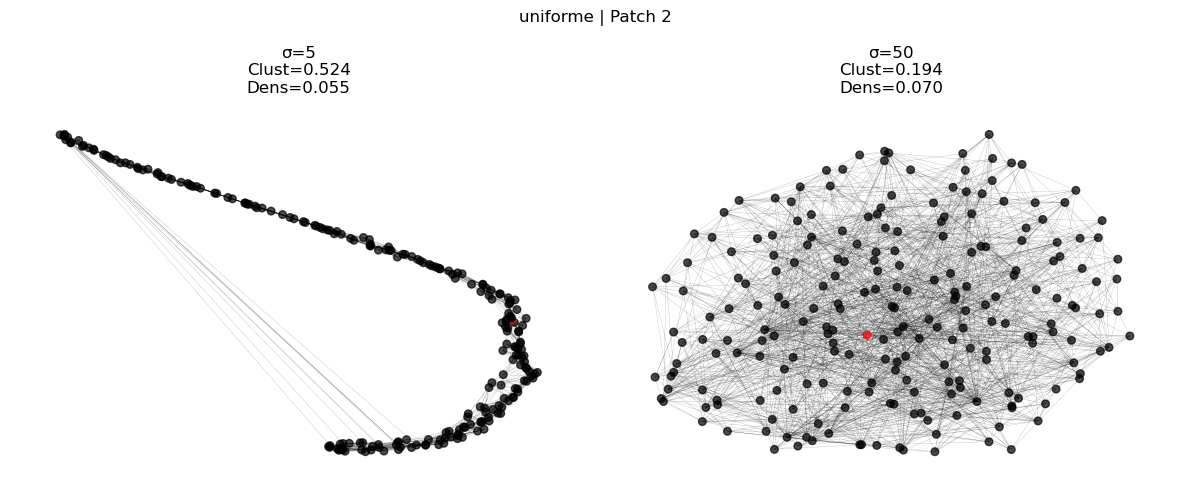

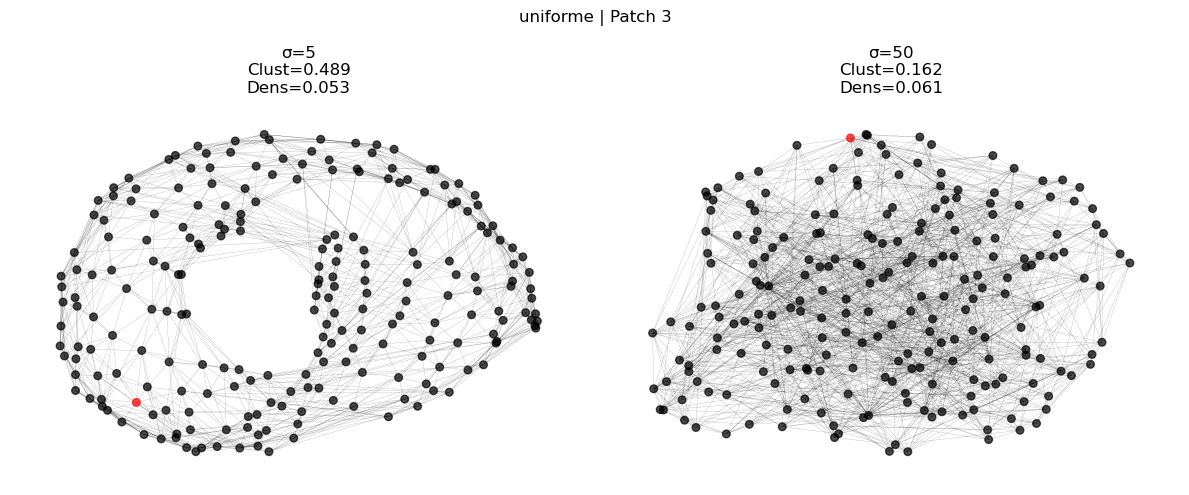

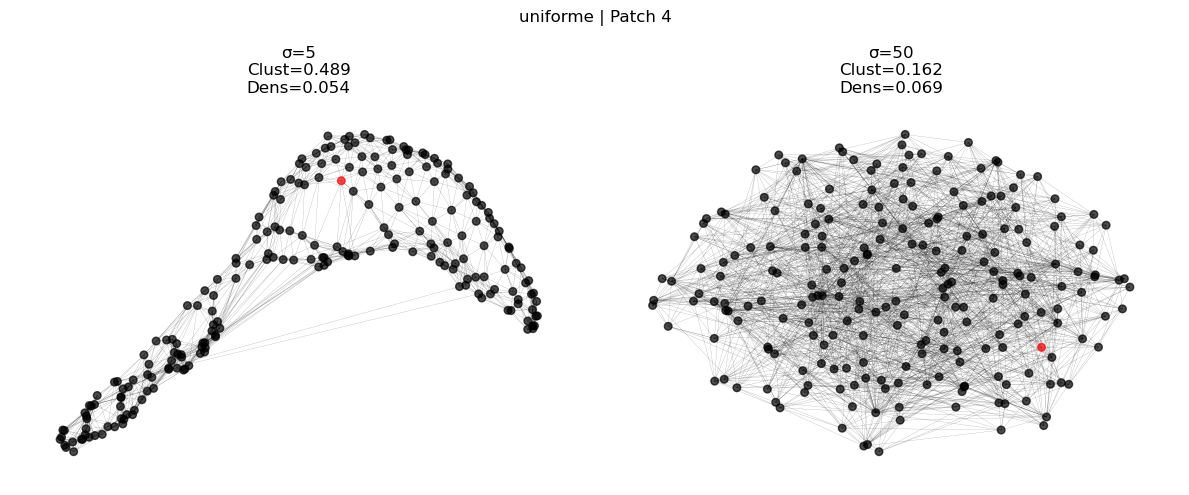

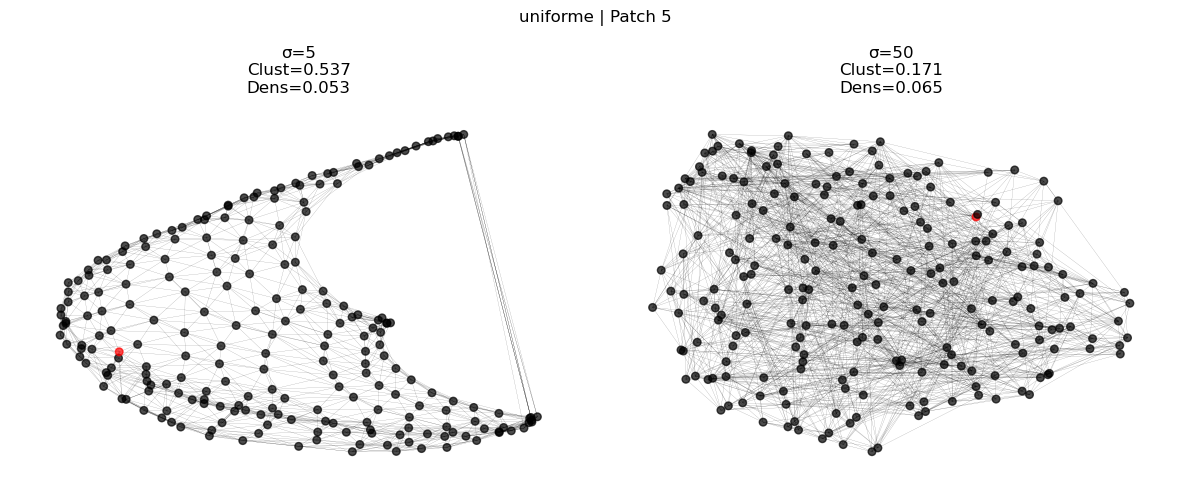


Processando tipo: nao_uniforme


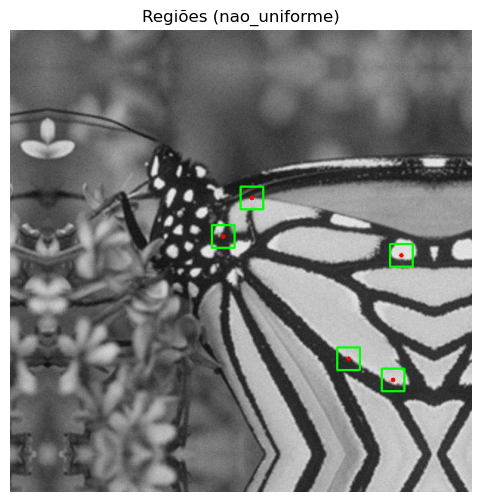


--- σ = 5 ---

--- σ = 50 ---


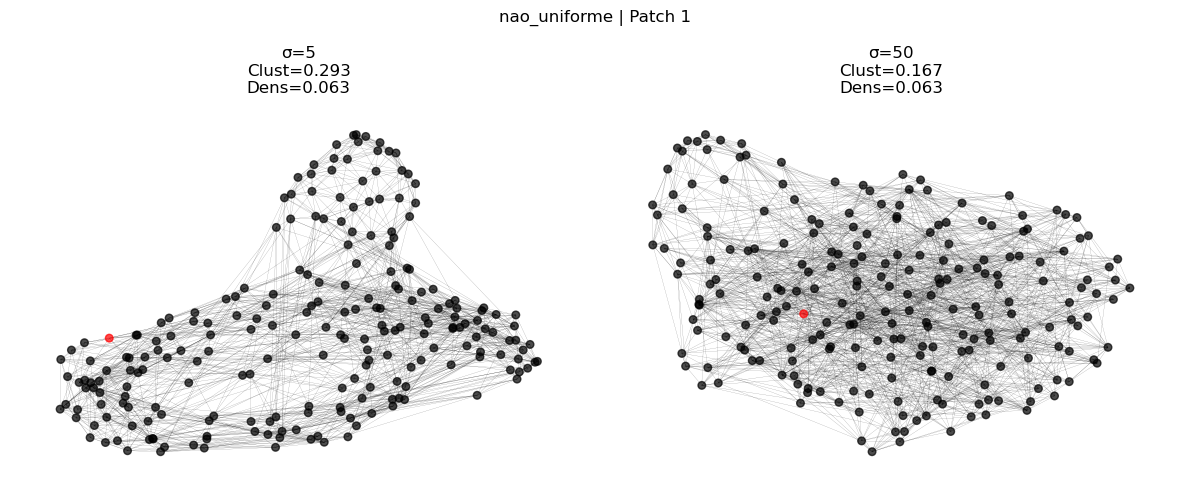

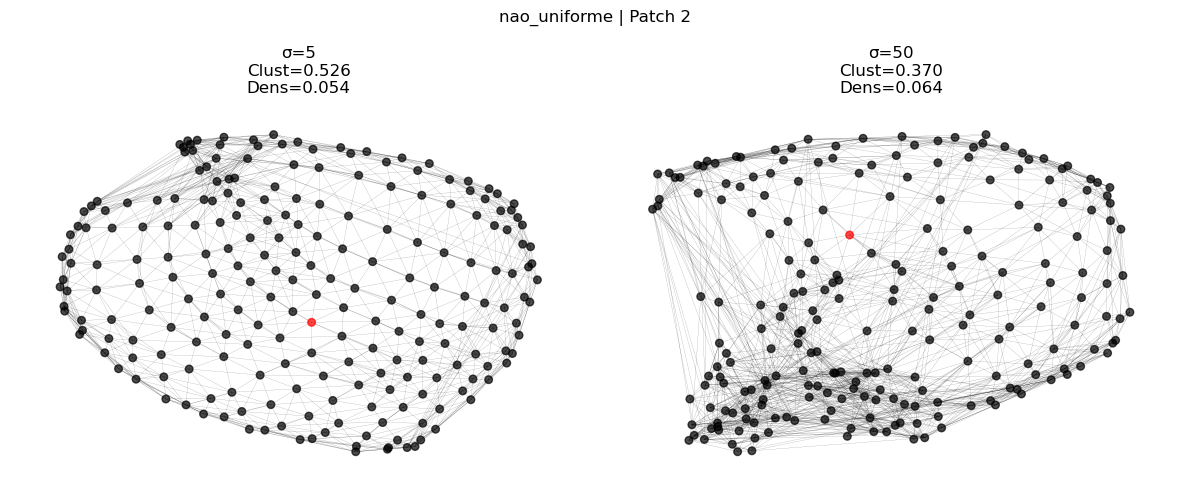

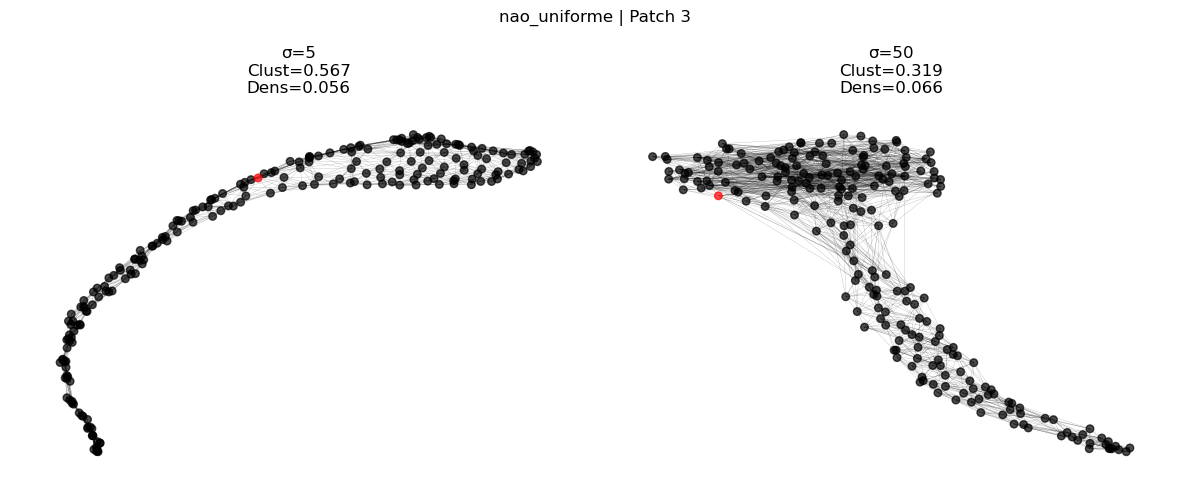

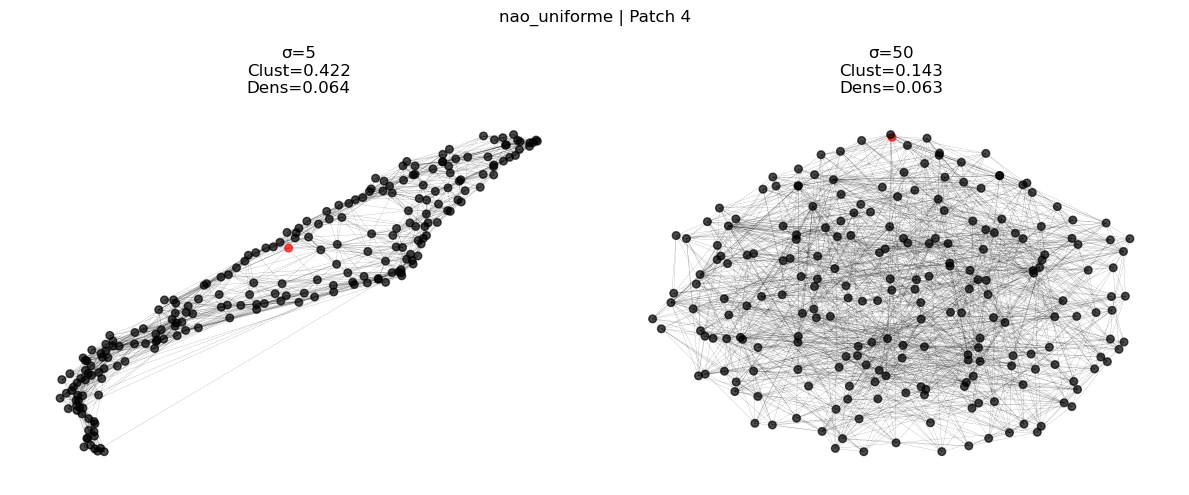

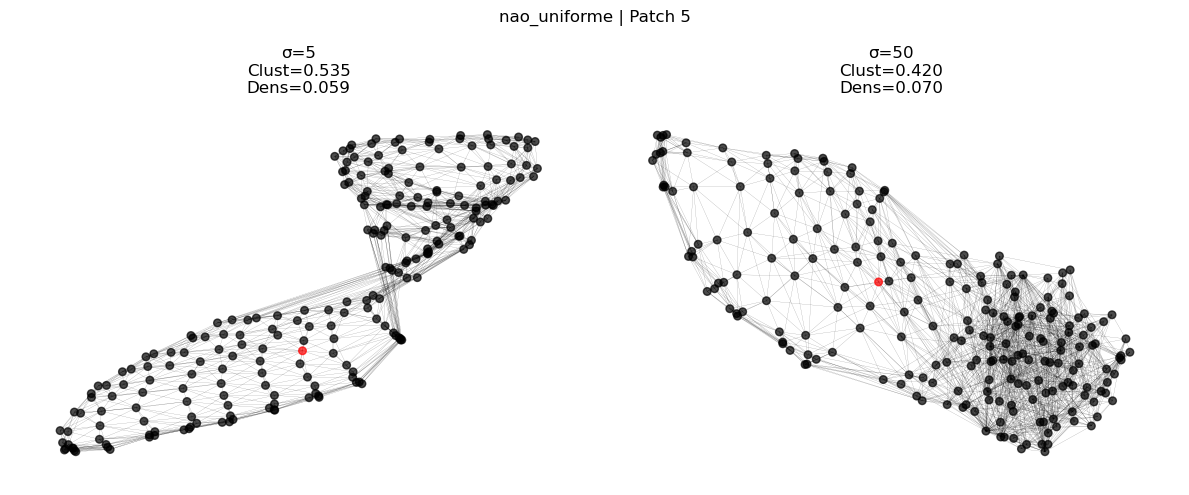


Processando tipo: mesclada


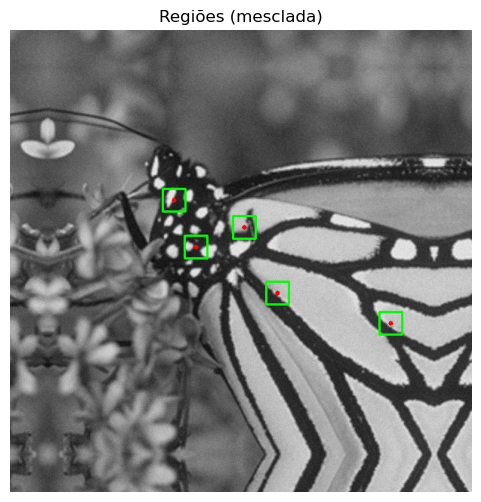


--- σ = 5 ---

--- σ = 50 ---


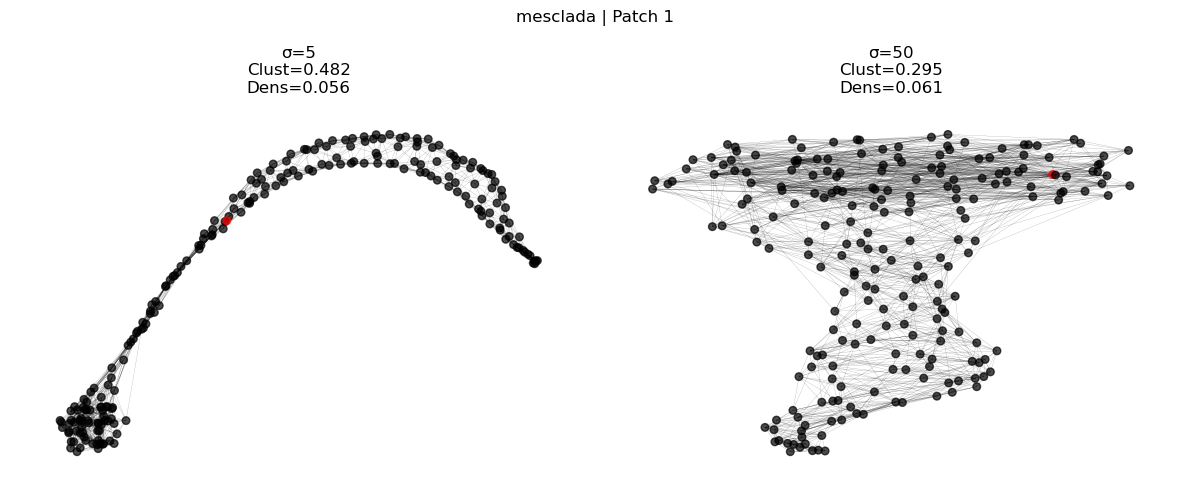

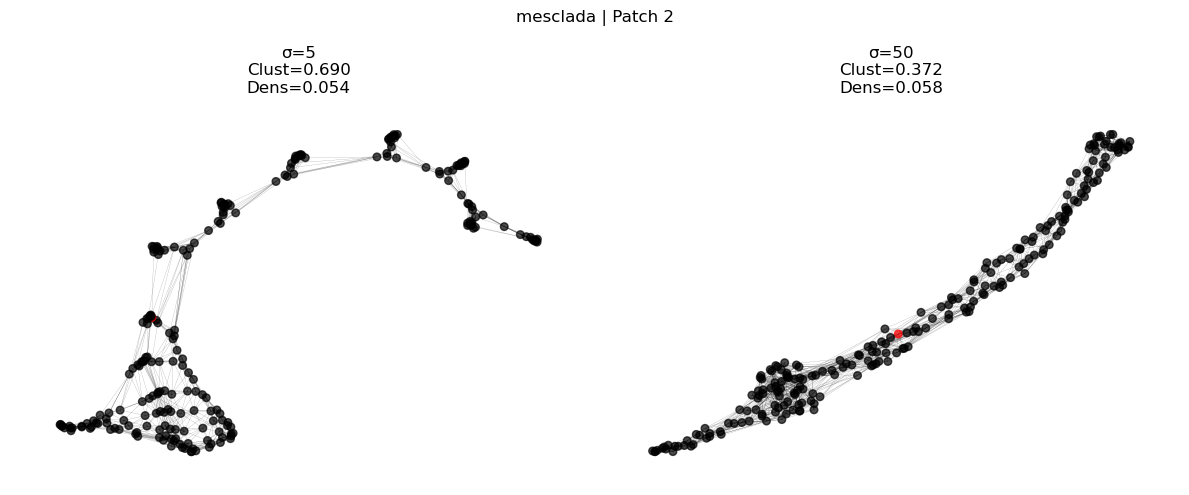

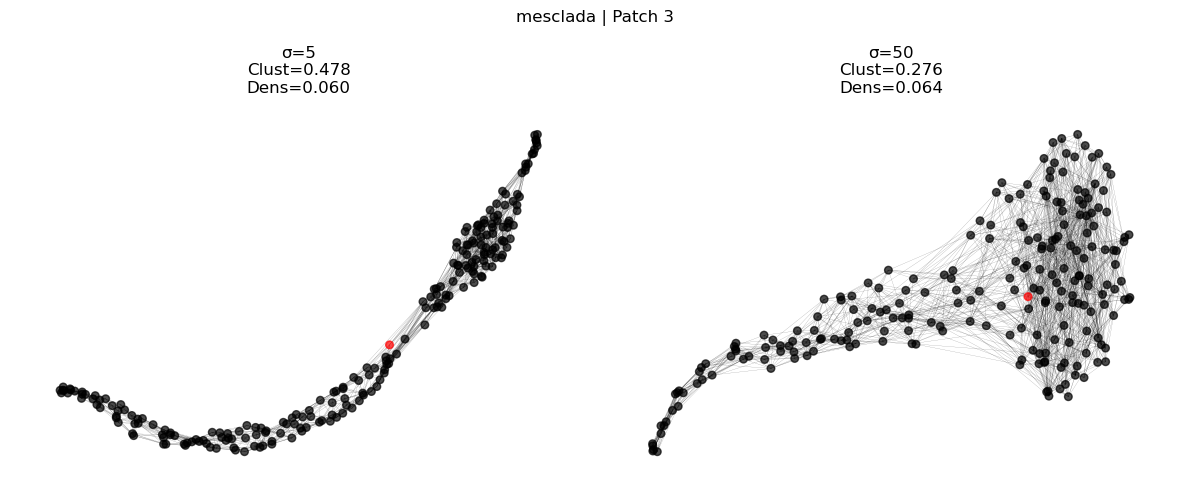

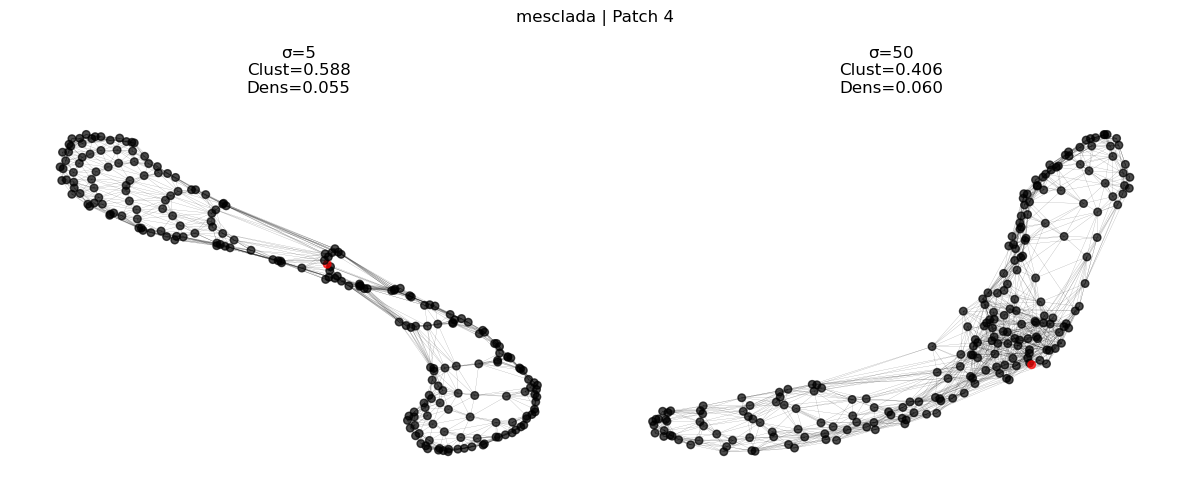

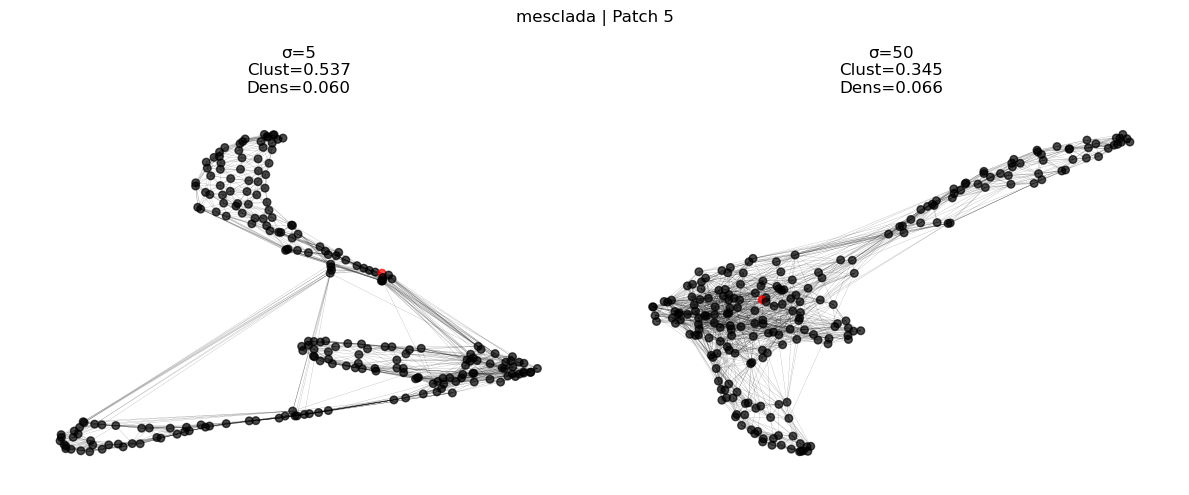


========== PATCH SPACE STRUCTURAL SUMMARY ==========
           Tipo  Sigma     UniqueRows          Rank            Energy  \
0      uniforme      5  225.00 ± 0.00  81.00 ± 0.00   148.90 ± 102.47   
1      uniforme     50  225.00 ± 0.00  81.00 ± 0.00  2459.72 ± 173.28   
2  nao_uniforme      5  225.00 ± 0.00  81.00 ± 0.00  1040.28 ± 769.88   
3  nao_uniforme     50  225.00 ± 0.00  81.00 ± 0.00  2723.54 ± 502.57   
4      mesclada      5  225.00 ± 0.00  81.00 ± 0.00  1617.54 ± 670.78   
5      mesclada     50  225.00 ± 0.00  81.00 ± 0.00  3255.23 ± 682.10   

   SpectralRatio  
0  0.653 ± 0.088  
1  0.222 ± 0.037  
2  0.445 ± 0.119  
3  0.161 ± 0.029  
4  0.415 ± 0.070  
5  0.175 ± 0.022  

Arquivo salvo com sucesso.


In [9]:
if __name__ == "__main__":

    import pandas as pd

    # ============================================================
    # LEITURA DA IMAGEM
    # ============================================================
    img = imread('/workspace/data/input/set12/05.png', as_gray=True)
    img = (255 * img).astype(np.uint8)
    img_gray_padded = np.pad(img, ((50, 50), (50, 50)), mode='symmetric')

    f = 4
    t = 7
    nn = 10

    tipos = ["uniforme", "nao_uniforme", "mesclada"]
    sigmas = [5, 50]

    results = {}
    summary_graph = {}

    # ============================================================
    # LOOP PRINCIPAL
    # ============================================================

    for tipo in tipos:

        print(f"\n==============================")
        print(f"Processando tipo: {tipo}")
        print(f"==============================")

        results[tipo] = {}
        summary_graph[tipo] = {}

        # ruído leve para detectar regiões
        noise_base = np.random.normal(0, 5, img_gray_padded.shape)
        base = np.clip(img_gray_padded + noise_base, 0, 255).astype(np.uint8)

        centers = detectar_regioes_por_tipo(
            base,
            f=25,           
            max_regioes=5,
            tipo=tipo
        )

        # ===============================
        # EXIBIR REGIÕES SELECIONADAS
        # ===============================
        img_rgb = cv2.cvtColor(base, cv2.COLOR_GRAY2RGB)
        fig_img = img_rgb.copy()

        for (cx, cy) in centers:
            cv2.rectangle(fig_img, (cx-15, cy-15), (cx+15, cy+15), (0,255,0), 2)
            cv2.circle(fig_img, (cx, cy), 3, (255,0,0), -1)

        plt.figure(figsize=(6,6))
        plt.imshow(fig_img)
        plt.title(f"Regiões ({tipo})")
        plt.axis("off")
        plt.show()

        # ===============================
        # PROCESSAR CADA SIGMA
        # ===============================
        for sigma in sigmas:

            print(f"\n--- σ = {sigma} ---")

            results[tipo][sigma] = {
                "graphs": [],
                "graph_metrics": [],
                "patch_metrics": [],
                "embeddings": []
            }

            for idx, center in enumerate(centers):

                noise = np.random.normal(0, sigma, img_gray_padded.shape)
                noised = np.clip(
                    img_gray_padded.astype(np.float32) + noise,
                    0, 255
                ).astype(np.uint8)

                patches, patch_center = Extract_patches_local(
                    noised,
                    center[0],
                    center[1],
                    f,
                    t
                )

                # ===============================
                # PATCH-SPACE MÉTRICAS
                # ===============================
                patch_metrics = compute_patchspace_metrics(patches)

                # ===============================
                # GRAFO
                # ===============================
                G = build_KNN_Graph(patches, nn)

                reducer = UMAP(n_components=2, random_state=42)
                embedding = reducer.fit_transform(patches)

                if hasattr(embedding, "get"):
                    embedding = embedding.get()

                graph_metrics = compute_graph_metrics(G, embedding, patch_center)

                # armazenar
                results[tipo][sigma]["graphs"].append(G)
                results[tipo][sigma]["graph_metrics"].append(graph_metrics)
                results[tipo][sigma]["patch_metrics"].append(patch_metrics)
                results[tipo][sigma]["embeddings"].append(embedding)

                # ===============================
                # EXIBIR GRAFOS COMPARATIVOS
                # ===============================
                if sigma == 5:
                    continue  # espera sigma 50

                fig, axes = plt.subplots(1, 2, figsize=(12,5))

                for i, s in enumerate([5, 50]):

                    G_plot = results[tipo][s]["graphs"][idx]
                    embedding_plot = results[tipo][s]["embeddings"][idx]
                    metrics_plot = results[tipo][s]["graph_metrics"][idx]

                    pos = {k: embedding_plot[k] for k in range(len(embedding_plot))}

                    colors = ["black"] * G_plot.number_of_nodes()
                    colors[patch_center] = "red"

                    nx.draw_networkx(
                        G_plot,
                        pos,
                        ax=axes[i],
                        node_color=colors,
                        node_size=30,
                        with_labels=False,
                        width=0.1,
                        alpha=0.7
                    )

                    axes[i].set_title(
                        f"σ={s}\nClust={metrics_plot['clustering']:.3f}\n"
                        f"Dens={metrics_plot['density']:.3f}"
                    )
                    axes[i].axis("off")

                plt.suptitle(f"{tipo} | Patch {idx+1}")
                plt.tight_layout()
                plt.show()

        # ===============================
        # MÉDIAS DE GRAFO
        # ===============================
        for sigma in sigmas:

            gm = results[tipo][sigma]["graph_metrics"]

            summary_graph[tipo][sigma] = {
                "avg_clustering": np.mean([m["clustering"] for m in gm]),
                "avg_density": np.mean([m["density"] for m in gm]),
                "avg_dist_center": np.mean([m["avg_dist_center"] for m in gm])
            }

    # ============================================================
    # TABELA PATCH-SPACE
    # ============================================================

    table_rows = []

    for tipo in tipos:
        for sigma in sigmas:

            pm = results[tipo][sigma]["patch_metrics"]

            unique_vals = [m["unique_rows"] for m in pm]
            rank_vals = [m["rank"] for m in pm]
            energy_vals = [m["energy"] for m in pm]
            spectral_vals = [m["spectral_ratio"] for m in pm]

            row = {
                "Tipo": tipo,
                "Sigma": sigma,
                "UniqueRows": f"{np.mean(unique_vals):.2f} ± {np.std(unique_vals):.2f}",
                "Rank": f"{np.mean(rank_vals):.2f} ± {np.std(rank_vals):.2f}",
                "Energy": f"{np.mean(energy_vals):.2f} ± {np.std(energy_vals):.2f}",
                "SpectralRatio": f"{np.mean(spectral_vals):.3f} ± {np.std(spectral_vals):.3f}"
            }

            table_rows.append(row)

    df_summary = pd.DataFrame(table_rows)

    print("\n========== PATCH SPACE STRUCTURAL SUMMARY ==========")
    print(df_summary)

    # ============================================================
    # SALVAR PICKLE
    # ============================================================

    with open("graph_analysis_results.pkl", "wb") as f:
        pickle.dump({
            "results": results,
            "graph_summary": summary_graph,
            "patchspace_table": df_summary
        }, f)

    print("\nArquivo salvo com sucesso.")


In [10]:
import pickle
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

if __name__ == "__main__":

    img = imread('/workspace/data/input/set12/05.png', as_gray=True)
    img = (255 * img).astype(np.uint8)

    pad = 50
    img_padded = np.pad(img, ((pad, pad), (pad, pad)), mode='symmetric')

    f = 4
    t = 7
    nn = 10

    tipos = ["uniforme", "nao_uniforme", "mesclada"]
    sigmas = [5, 50]

    dataset = {}

    for tipo in tipos:

        print(f"\nProcessando tipo: {tipo}")
        dataset[tipo] = []

        centers = detectar_regioes_por_tipo(
            img_padded,
            f=25,
            max_regioes=5,
            tipo=tipo
        )

        for center in centers:

            cx, cy = center

            # ======================
            # RECORTE 50x50 LIMPO
            # ======================
            half = 25
            patch_clean = img_padded[
                cy-half:cy+half,
                cx-half:cx+half
            ].copy()

            entry = {
                "center": center,
                "clean": patch_clean,
                "noisy": {},
                "graphs": {}
            }

            for sigma in sigmas:

                noise = np.random.normal(0, sigma, img_padded.shape)
                noisy_full = np.clip(
                    img_padded.astype(np.float32) + noise,
                    0, 255
                ).astype(np.uint8)

                patch_noisy = noisy_full[
                    cy-half:cy+half,
                    cx-half:cx+half
                ].copy()

                entry["noisy"][sigma] = patch_noisy

                # ======================
                # GERAR GRAFO LOCAL
                # ======================
                patches_local, patch_center = Extract_patches_local(
                    noisy_full,
                    cx,
                    cy,
                    f,
                    t
                )

                G = build_KNN_Graph(patches_local, nn)
                entry["graphs"][sigma] = G

            dataset[tipo].append(entry)

    # ======================
    # SALVAR PICKLE
    # ======================
    with open("regional_experiment_dataset.pkl", "wb") as f:
        pickle.dump(dataset, f)

    print("\nDataset salvo como regional_experiment_dataset.pkl")



Processando tipo: uniforme

Processando tipo: nao_uniforme

Processando tipo: mesclada

Dataset salvo como regional_experiment_dataset.pkl
